# 1. Library

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, mean_absolute_percentage_error
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import joblib
import pickle
import shap
import concurrent.futures
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
#from sktime.performance_metrics.forecasting import mean_squared_percentage_error, median_absolute_percentage_error, mean_relative_absolute_error, median_relative_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
file_path = r"C:\Users\james\J_Data_Lab\Project_subway\data\df_subway_v34.csv"
df = pd.read_csv(file_path)
df

날짜  호선   역명  시간  승차인원  하차인원  우대권인원수  청소년인원수  기온(°C)  강수량(mm)  \
0        2021-01-01   1  서울역   5    81    82      62       5    -9.7      0.0   
1        2021-01-01   1  서울역   5    81    82      62       5    -9.7      0.0   
2        2021-01-01   1  서울역   6   111   352     111       2    -9.7      0.0   
3        2021-01-01   1  서울역   6   111   352     111       2    -9.7      0.0   
4        2021-01-01   1  서울역   7   154   434     129       5    -9.3      0.0   
...             ...  ..  ...  ..   ...   ...     ...     ...     ...      ...   
1649011  2023-12-31   8   잠실  21  1417   582     110     131     1.7      0.0   
1649012  2023-12-31   8   잠실  22   908   697      78     139     1.3      0.0   
1649013  2023-12-31   8   잠실  22   908   697      78     139     1.3      0.0   
1649014  2023-12-31   8   잠실  23  1569  1126      76     239     0.9      0.0   
1649015  2023-12-31   8   잠실  23  1569  1126      76     239     0.9      0.0   

         ...      λ_환승    λ_total    W_승차  W_환승   W_total     L_total  \
0        ...  0.045385   2.762052  2.8350   1.5  2.813064    7.769828   
1        ...  0.045385   2.762052  2.8350   1.5  2.813064    7.769828   
2        ...  0.128917   7.845583  2.6725   1.5  2.653234   20.816167   
3        ...  0.128917   7.845583  2.6725   1.5  2.653234   20.816167   
4        ...  0.163721   9.963721  2.2225   1.5  2.210628   22.026082   
...      ...       ...        ...     ...   ...       ...         ...   
1649011  ...  0.079932  33.396599  4.0000   1.5  3.994016  133.386565   
1649012  ...  0.064178  26.814178  4.3825   1.5  4.375601  117.328141   
1649013  ...  0.064178  26.814178  4.3825   1.5  4.375601  117.328141   
1649014  ...  0.107762  45.024429  4.8250   1.5  4.817042  216.884560   
1649015  ...  0.107762  45.024429  4.8250   1.5  4.817042  216.884560   

          승강장_혼잡도   주    년도   월  
0        0.000719   1  2021   1  
1        0.000719   1  2021   1  
2        0.001927   1  2021   1  
3        0.001927   1  2021   1  
4        0.002039   1  2021   1  
...           ...  ..   ...  ..  
1649011  0.008498  52  2023  12  
1649012  0.007475  52  2023  12  
1649013  0.007475  52  2023  12  
1649014  0.013818  52  2023  12  
1649015  0.013818  52  2023  12  

[1649016 rows x 71 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649016 entries, 0 to 1649015
Data columns (total 71 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   날짜            1649016 non-null  object 
 1   호선            1649016 non-null  int64  
 2   역명            1649016 non-null  object 
 3   시간            1649016 non-null  int64  
 4   승차인원          1649016 non-null  int64  
 5   하차인원          1649016 non-null  int64  
 6   우대권인원수        1649016 non-null  int64  
 7   청소년인원수        1649016 non-null  int64  
 8   기온(°C)        1649016 non-null  float64
 9   강수량(mm)       1649016 non-null  float64
 10  풍속(m/s)       1649016 non-null  float64
 11  습도(%)         1649016 non-null  int64  
 12  적설(cm)        1649016 non-null  float64
 13  승하차인원         1649016 non-null  int64  
 14  출입구           1649016 non-null  int64  
 15  섬식여부          1649016 non-null  int64  
 16  환승노선_개수       1649016 non-null  int64  
 17  면적            1649016 non-n

# 2. Prep

In [4]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # 수송인원 10개 필터링
    top_stations = ['홍대입구', '잠실', '강남', '서울역', '신림', '고속터미널', '신도림', '역삼', '선릉', '을지로입구'] 
    
    
    df = df[df['역명'].isin(top_stations)].reset_index(drop=True)
    
    selected_columns = df.columns
    
    # 제외할 변수 지정
    #excluded_columns = ['역명', '면적', '승강장혼잡도2', '승강장혼잡도1', '날짜', '수송인원수', 'L_total', 'λ_total',
     #                   'W_total', 'W_환승', 'λ_환승', 'W_승차', 'λ_승차', '승강장_혼잡도', '요일구분','승하차인원','일별_승하차인원_합','호선'
     #                   ,'시간대별_환승_승객_수','시간대별_승하차_비율']
    
   # feature_columns = [col for col in selected_columns if col not in excluded_columns]

    # 공공데이터포털 DB만 사용.
    feature_columns = ['주', '년도', '월', '공휴일여부', '요일_Monday', '요일_Tuesday', '요일_Wednesday', '요일_Thursday', '요일_Friday', 
                       '요일_Saturday', '요일_Sunday', '시간', '승차인원', '하차인원', '우대권인원수', '청소년인원수', 
                       '상선 혼잡도', '하선 혼잡도', '환승유입인원수', '섬식여부', '출입구', '환승노선_개수', '수송인원수']
    
    # 독립 변수와 종속 변수 분리
    X = df[feature_columns]
    y = df['승강장혼잡도1']
    
    # 학습용과 테스트용 데이터로 분할
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 결과를 딕셔너리 형태로 반환
    data = {
        'X_train': X_train,
        'Y_train': Y_train,
        'X_test': X_test,
        'Y_test': Y_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'feature_columns': feature_columns,
        'scaler': scaler,  # 추가
        'df_train': df.iloc[X_train.index],
        'df_test': df.iloc[X_test.index]
    }
    
    return data

# 데이터 전처리
data = preprocess_data(file_path)

In [5]:
def mean_squared_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  
    return np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2)

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

# 3. Model

In [6]:
def model_linear(X_train_scaled, Y_train):
    model = LinearRegression()
    model.fit(X_train_scaled, Y_train)
    return model

def model_rf(X_train_scaled, Y_train):
    model = RandomForestRegressor(n_estimators=50, random_state=0)
    model.fit(X_train_scaled, Y_train)
    return model

def model_xgb(X_train_scaled, Y_train):
    params = {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'random_state': 0
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train_scaled, Y_train)
    return model

def model_lightgbm(X_train_scaled, Y_train):
    model = lgb.LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=0)
    model.fit(X_train_scaled, Y_train)
    return model

def model_catboost(X_train_scaled, Y_train):
    model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_state=0, silent=True)
    model.fit(X_train_scaled, Y_train)
    return model

def model_mlp(X_train_scaled, Y_train):
    model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=0)
    model.fit(X_train_scaled, Y_train)
    return model

def model_cnn(X_train_scaled, Y_train):
    X_train_scaled_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    
    model = Sequential([
        Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train_scaled_reshaped, Y_train, epochs=10, batch_size=32, verbose=0)
    
    return model

In [7]:
def calculate_metrics(Y_true, Y_pred):
    return {
        'mse': mean_squared_error(Y_true, Y_pred),
        'rmse': mean_squared_error(Y_true, Y_pred, squared=False),
        'mspe': mean_squared_percentage_error(Y_true, Y_pred),
        'mae': mean_absolute_error(Y_true, Y_pred),
        'medae': median_absolute_error(Y_true, Y_pred),
        'medape': median_absolute_percentage_error(Y_true, Y_pred)
    }

# 4. 평가

In [8]:
# 모델들을 딕셔너리로 정의
models = {
    'Linear Regression': model_linear,
    'Random Forest': model_rf,
    'XGBoost': model_xgb,
    'LightGBM': model_lightgbm,
    'CatBoost': model_catboost,
    'MLP': model_mlp,
    'CNN': model_cnn
}

# 결과 저장을 위한 빈 리스트 초기화
result_list = []

# 모델 학습 및 저장
trained_models = {}
for model_name, model_func in models.items():
    print(f'--- {model_name} 모델 학습 ---')
    if model_name == 'CNN':
        X_train_model_input = data['X_train_scaled'].reshape(-1, data['X_train_scaled'].shape[1], 1)
    else:
        X_train_model_input = data['X_train_scaled']
    best_model = model_func(X_train_model_input, data['Y_train'])
    trained_models[model_name] = best_model

--- Linear Regression 모델 학습 ---
--- Random Forest 모델 학습 ---
--- XGBoost 모델 학습 ---
--- LightGBM 모델 학습 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 442635, number of used features: 23
[LightGBM] [Info] Start training from score 59.943059
--- CatBoost 모델 학습 ---
--- MLP 모델 학습 ---
--- CNN 모델 학습 ---


In [10]:
top_stations = ['홍대입구', '잠실', '강남', '서울역', '신림', '고속터미널', '신도림', '역삼', '선릉', '을지로입구']

def evaluate_station_model(station_name):
    station_results = []
    station_data = data['df_test'][data['df_test']['역명'] == station_name]
    lines = station_data['호선'].unique()
    
    for line in lines:
        line_data = station_data[station_data['호선'] == line]
        X_test_station_scaled = data['scaler'].transform(line_data[data['feature_columns']])
        Y_test_station = line_data['승강장혼잡도1']
        
        for model_name, best_model in trained_models.items():
            print(f'\n\n--- {station_name} ({line}호선) - {model_name} 모델 학습 및 평가 ---\n')
            try:
                if model_name == 'CNN':
                    X_test_model_input = X_test_station_scaled.reshape(-1, X_test_station_scaled.shape[1], 1)
                else:
                    X_test_model_input = X_test_station_scaled

                # 예측값 계산
                Y_test_pred = best_model.predict(X_test_model_input)
                if model_name == 'CNN':
                    Y_test_pred = Y_test_pred.flatten()

                # 성능 지표 계산
                test_metrics = calculate_metrics(Y_test_station, Y_test_pred)

                result = {
                    '역명': station_name,
                    '호선': line,
                    '알고리즘': model_name,
                    '실제값 평균': round(Y_test_station.mean(), 6),
                    '예측값 평균': round(Y_test_pred.mean(), 6),
                    'MSE': round(test_metrics['mse'], 6),
                    'RMSE': round(test_metrics['rmse'], 6),
                    'MSPE': round(test_metrics['mspe'], 6),
                    'MAE': round(test_metrics['mae'], 6),
                    'MAPE': round(mean_absolute_percentage_error(Y_test_station, Y_test_pred), 6),
                    'MedAE': round(test_metrics['medae'], 6),
                    'MedAPE': round(test_metrics['medape'], 6)
                }
                station_results.append(result)
            except Exception as e:
                print(f"{station_name} ({line}호선) - {model_name} 모델 평가 중 오류 발생: {e}")
    return station_results


    
# 병렬 실행
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(evaluate_station_model, station_name) for station_name in top_stations]
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            result_list.extend(result)

# 최종 결과 데이터프레임 생성
final_results_df = pd.DataFrame(result_list)



--- 홍대입구 (2호선) - Linear Regression 모델 학습 및 평가 ---



--- 강남 (2호선) - Linear Regression 모델 학습 및 평가 ---



--- 잠실 (2호선) - Linear Regression 모델 학습 및 평가 ---



--- 서울역 (1호선) - Linear Regression 모델 학습 및 평가 ---



--- 홍대입구 (2호선) - Random Forest 모델 학습 및 평가 ---



--- 잠실 (2호선) - Random Forest 모델 학습 및 평가 ---



--- 강남 (2호선) - Random Forest 모델 학습 및 평가 ---



--- 서울역 (1호선) - Random Forest 모델 학습 및 평가 ---



--- 홍대입구 (2호선) - XGBoost 모델 학습 및 평가 ---



--- 잠실 (2호선) - XGBoost 모델 학습 및 평가 ---



--- 강남 (2호선) - XGBoost 모델 학습 및 평가 ---



--- 홍대입구 (2호선) - LightGBM 모델 학습 및 평가 ---



--- 서울역 (1호선) - XGBoost 모델 학습 및 평가 ---



--- 잠실 (2호선) - LightGBM 모델 학습 및 평가 ---



--- 강남 (2호선) - LightGBM 모델 학습 및 평가 ---



--- 서울역 (1호선) - LightGBM 모델 학습 및 평가 ---



--- 홍대입구 (2호선) - CatBoost 모델 학습 및 평가 ---



--- 잠실 (2호선) - CatBoost 모델 학습 및 평가 ---



--- 강남 (2호선) - CatBoost 모델 학습 및 평가 ---



--- 서울역 (1호선) - CatBoost 모델 학습 및 평가 ---



--- 홍대입구 (2호선) - MLP 모델 학습 및 평가 ---



--- 강남 (2호선) - MLP 모델 학습 및 평가 ---



--- 잠실 (2호선) - 

In [11]:
pd.set_option('display.max_rows', None)
final_results_df

역명  호선               알고리즘      실제값 평균      예측값 평균          MSE  \
0      강남   2  Linear Regression  146.920402  124.964389  1005.807243   
1      강남   2      Random Forest  146.920402  146.850231     0.427417   
2      강남   2            XGBoost  146.920402  146.306564    24.075628   
3      강남   2           LightGBM  146.920402  146.331240    28.625804   
4      강남   2           CatBoost  146.920402  145.927732    34.020664   
5      강남   2                MLP  146.920402  147.043322     0.139262   
6      강남   2                CNN  146.920402  146.502258     0.665700   
7    홍대입구   2  Linear Regression  102.607423   88.903727   232.559886   
8    홍대입구   2      Random Forest  102.607423  102.644694     0.394752   
9    홍대입구   2            XGBoost  102.607423  102.246834    11.716305   
10   홍대입구   2           LightGBM  102.607423  102.054004    15.668615   
11   홍대입구   2           CatBoost  102.607423  101.612850    20.997387   
12   홍대입구   2                MLP  102.607423  102.832876     0.134090   
13   홍대입구   2                CNN  102.607423  102.587227     0.155528   
14     신림   2  Linear Regression   96.961763  106.515249   186.966676   
15     신림   2      Random Forest   96.961763   96.913142     0.175781   
16     신림   2            XGBoost   96.961763   97.038933    13.634122   
17     신림   2           LightGBM   96.961763   96.966631     9.374647   
18     신림   2           CatBoost   96.961763   96.964488    13.655930   
19     신림   2                MLP   96.961763   97.064158     0.057986   
20     신림   2                CNN   96.961763   96.945251     0.127227   
21    서울역   1  Linear Regression   51.944493   54.781375    78.087848   
22    서울역   1      Random Forest   51.944493   51.986829     0.104145   
23    서울역   1            XGBoost   51.944493   52.296719     6.581680   
24    서울역   1           LightGBM   51.944493   52.221789     9.125230   
25    서울역   1           CatBoost   51.944493   52.343740    10.254857   
26    서울역   1                MLP   51.944493   51.876439     0.068921   
27    서울역   1                CNN   51.944493   52.082657     0.085868   
28    서울역   4  Linear Regression   18.474888   19.692043    29.912933   
29    서울역   4      Random Forest   18.474888   18.462230     0.015776   
30    서울역   4            XGBoost   18.474888   18.351974     1.087685   
31    서울역   4           LightGBM   18.474888   18.313543     1.014783   
32    서울역   4           CatBoost   18.474888   18.386405     2.690654   
33    서울역   4                MLP   18.474888   18.545286     0.045161   
34    서울역   4                CNN   18.474888   18.602180     0.049597   
35     잠실   2  Linear Regression   85.771717  104.831806   543.552399   
36     잠실   2      Random Forest   85.771717   85.787359     0.558458   
37     잠실   2            XGBoost   85.771717   86.028358    10.473416   
38     잠실   2           LightGBM   85.771717   85.950771    15.984611   
39     잠실   2           CatBoost   85.771717   86.041844    16.424583   
40     잠실   2                MLP   85.771717   85.861832     0.246057   
41     잠실   2                CNN   85.771717   85.589561     0.721888   
42     잠실   8  Linear Regression   12.925087    7.316087   132.636054   
43     잠실   8      Random Forest   12.925087   12.937780     0.026765   
44     잠실   8            XGBoost   12.925087   13.182194     2.305090   
45     잠실   8           LightGBM   12.925087   13.286155     1.879879   
46     잠실   8           CatBoost   12.925087   13.849719     4.420501   
47     잠실   8                MLP   12.925087   12.916960     0.070997   
48     잠실   8                CNN   12.925087   12.912167     0.051171   
49  고속터미널   3  Linear Regression   32.686002   40.276988   248.624298   
50  고속터미널   3      Random Forest   32.686002   32.693877     0.168416   
51  고속터미널   3            XGBoost   32.686002   33.134655     7.268096   
52  고속터미널   3           LightGBM   32.686002   33.325119    10.042116   
53  고속터미널   3           CatBoost   32.686002   34.238565    19.62

# 5. 시각화

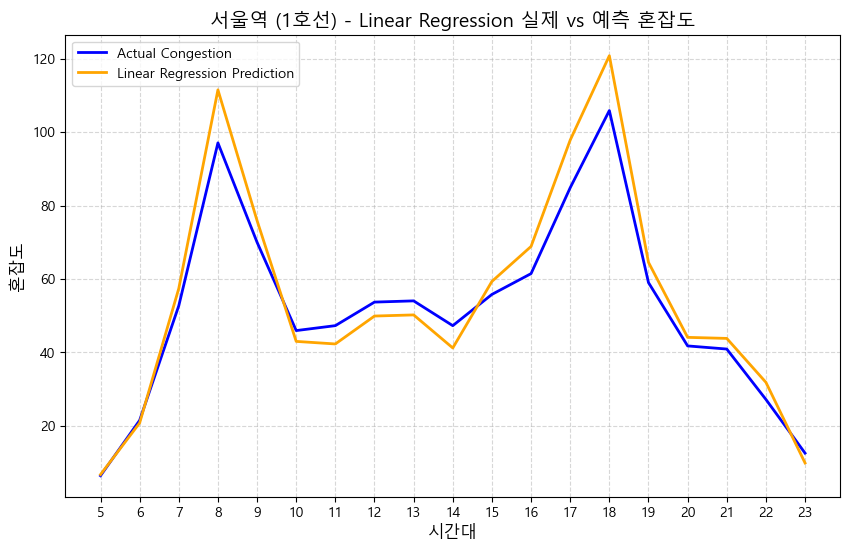

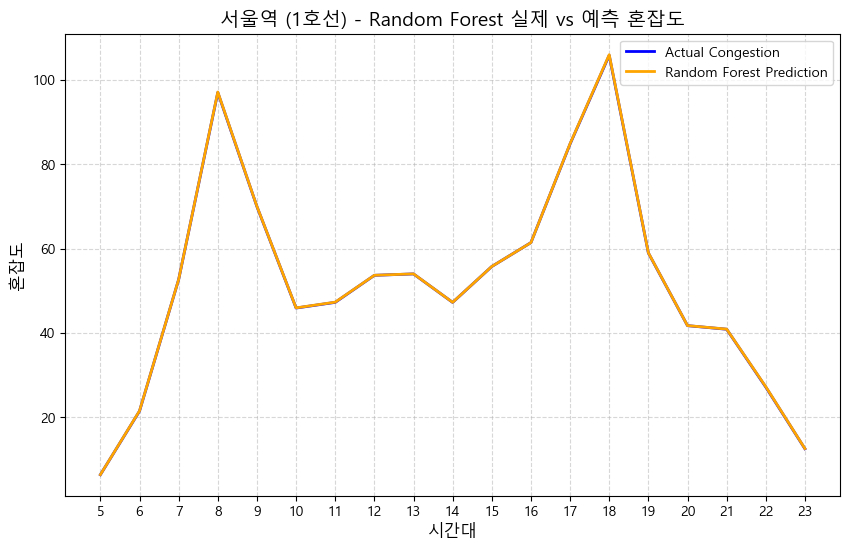

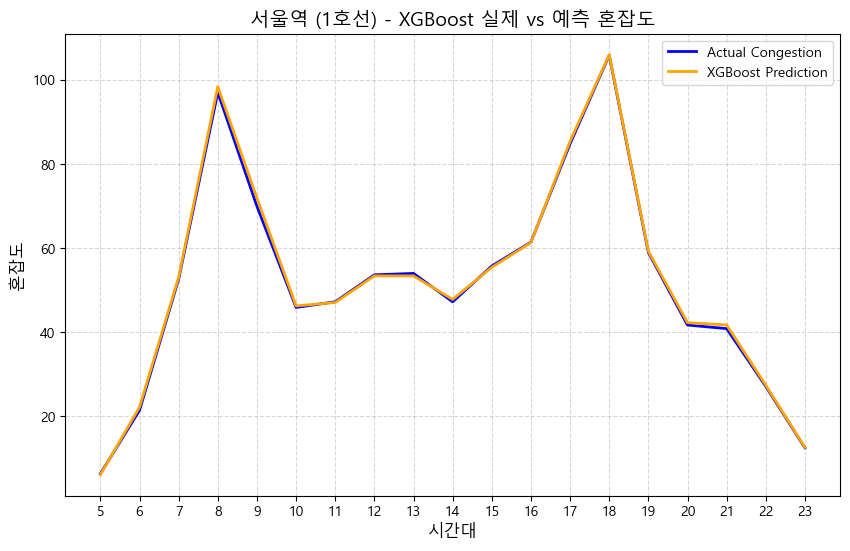

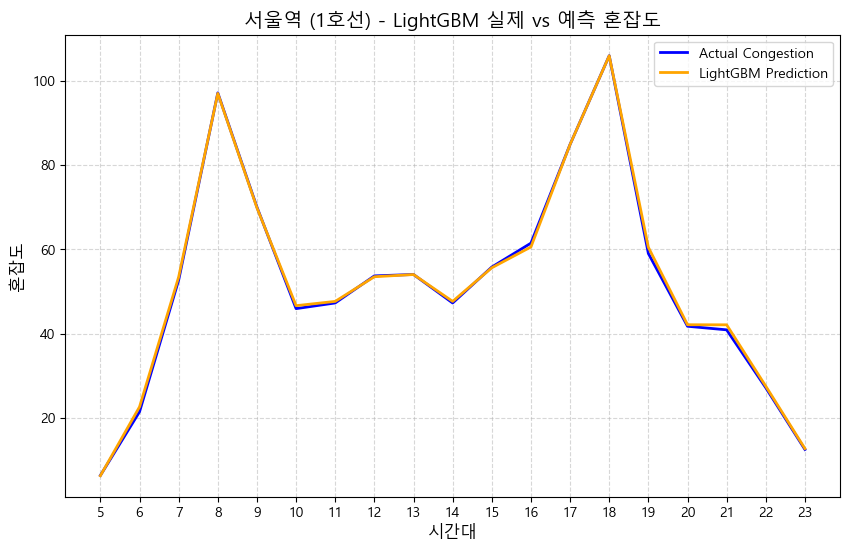

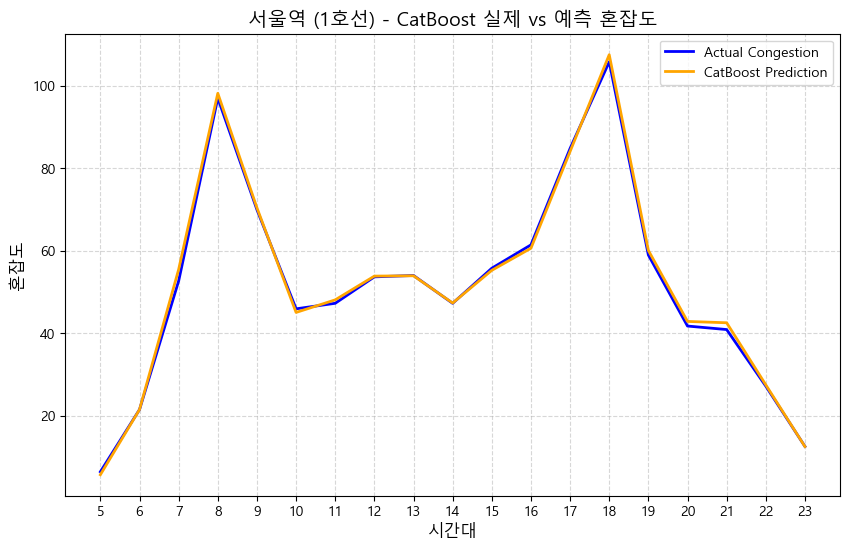

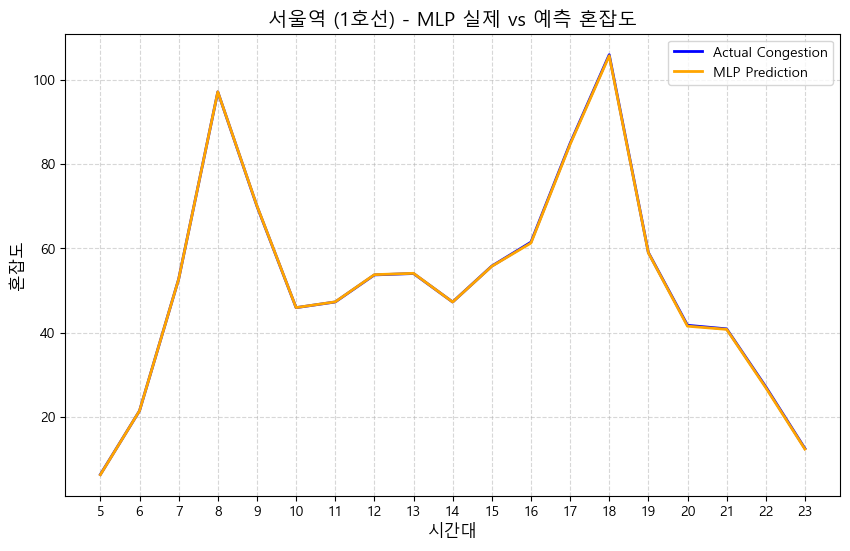

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


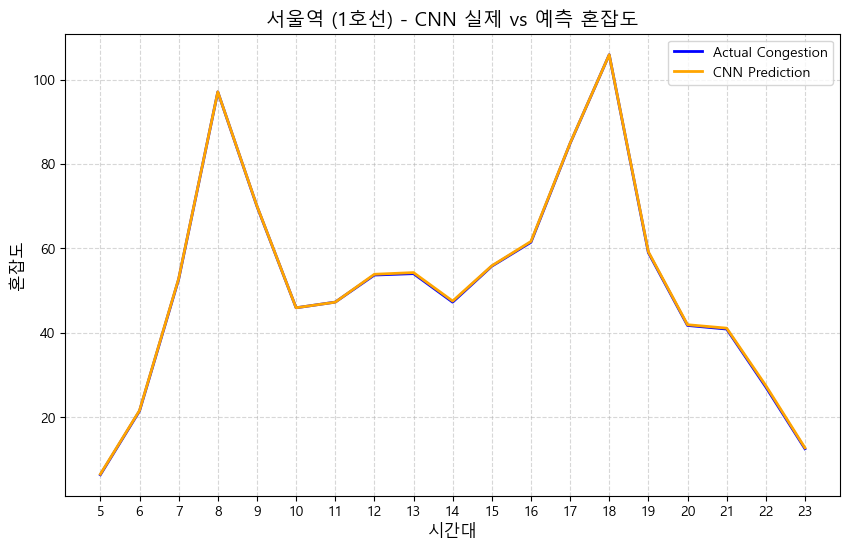

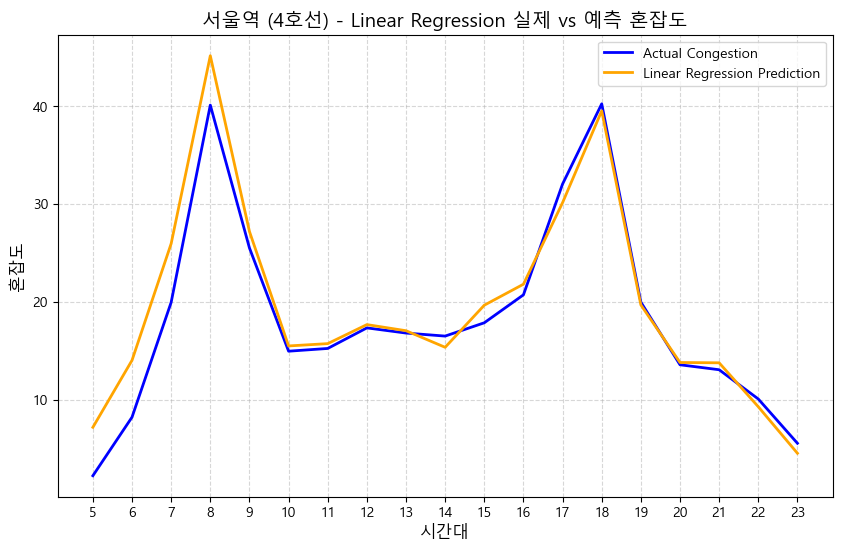

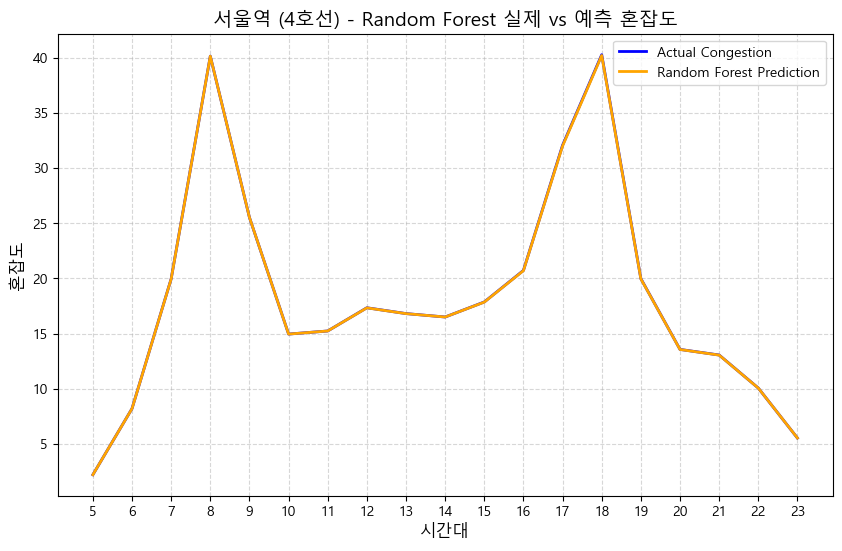

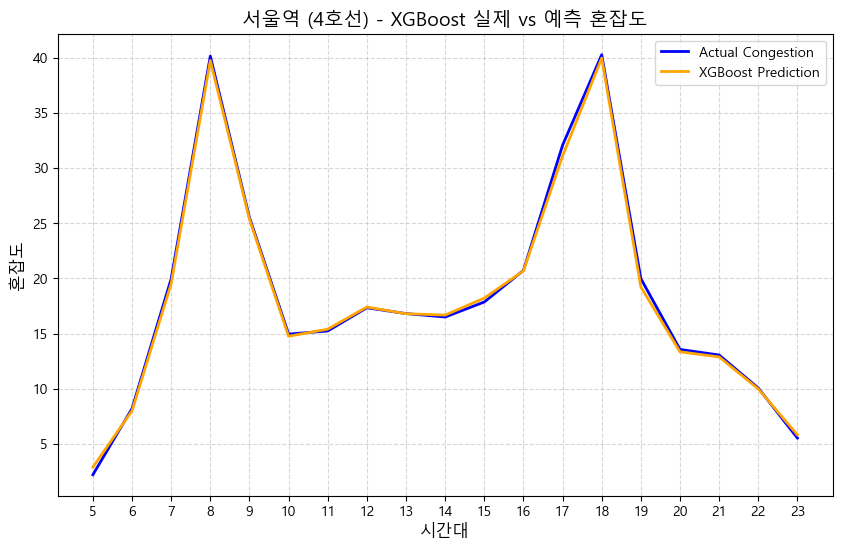

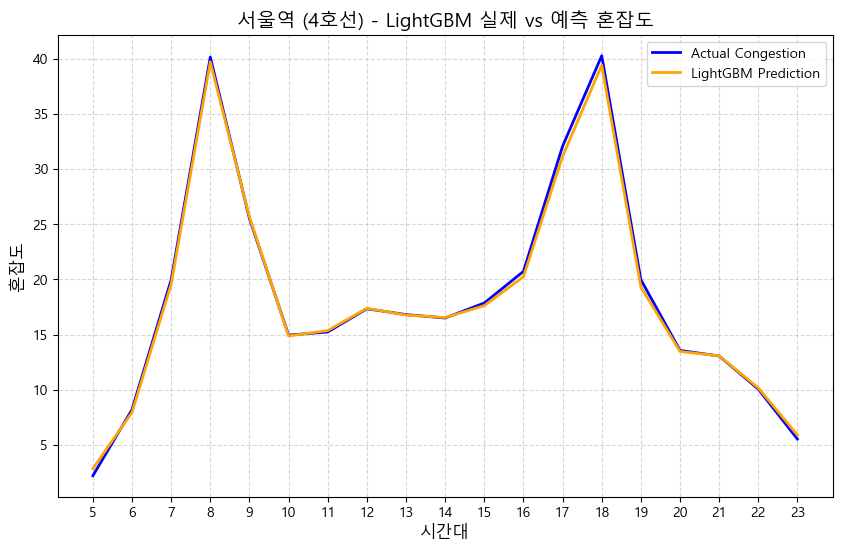

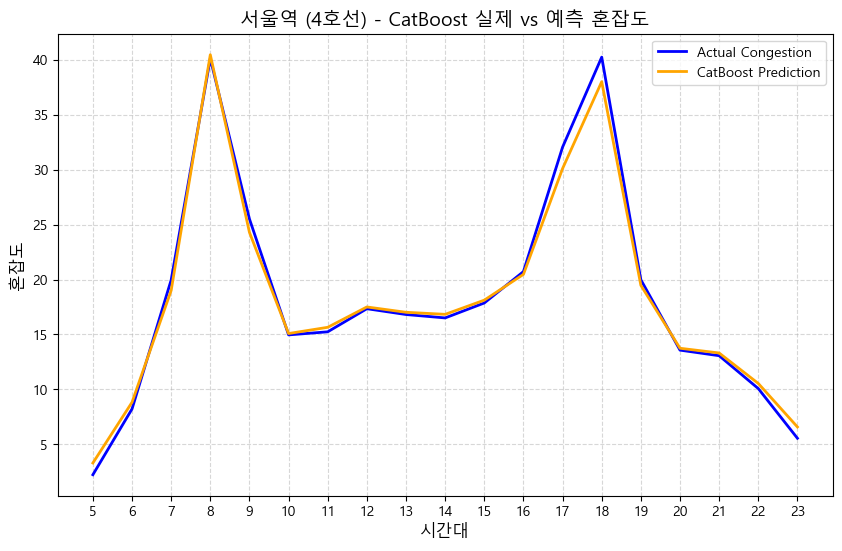

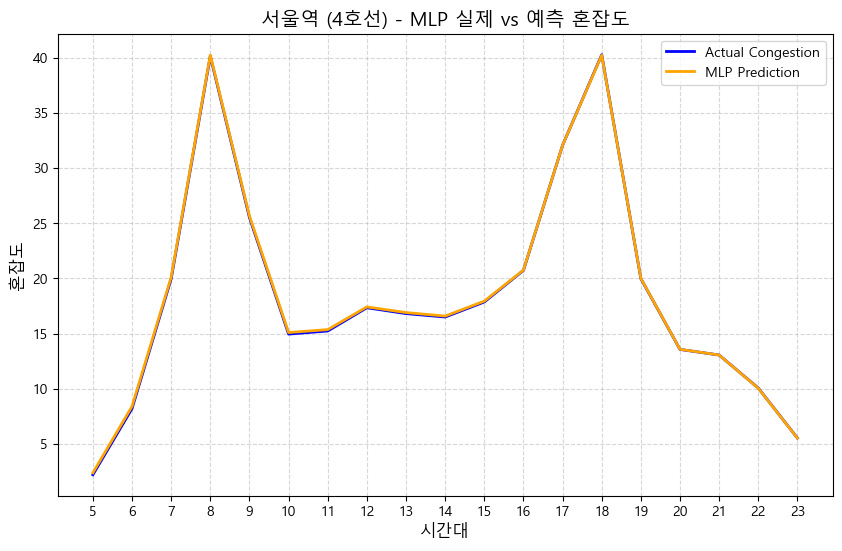

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


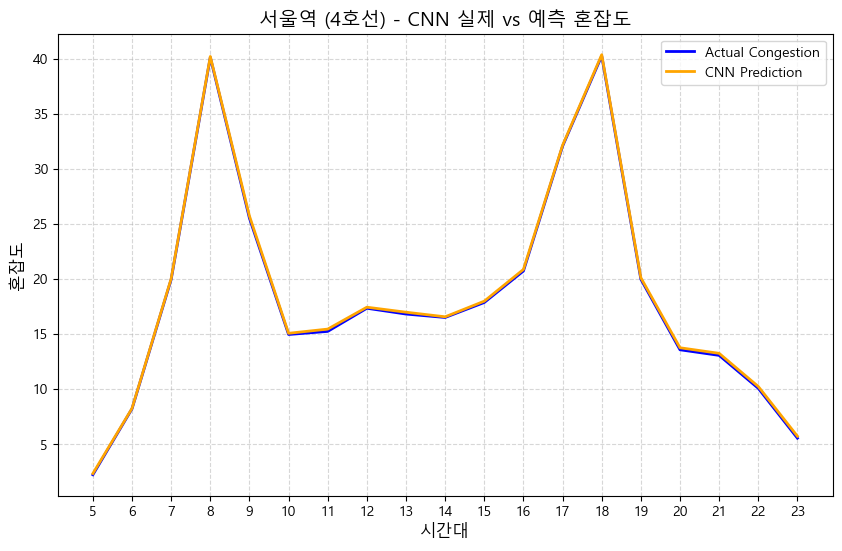

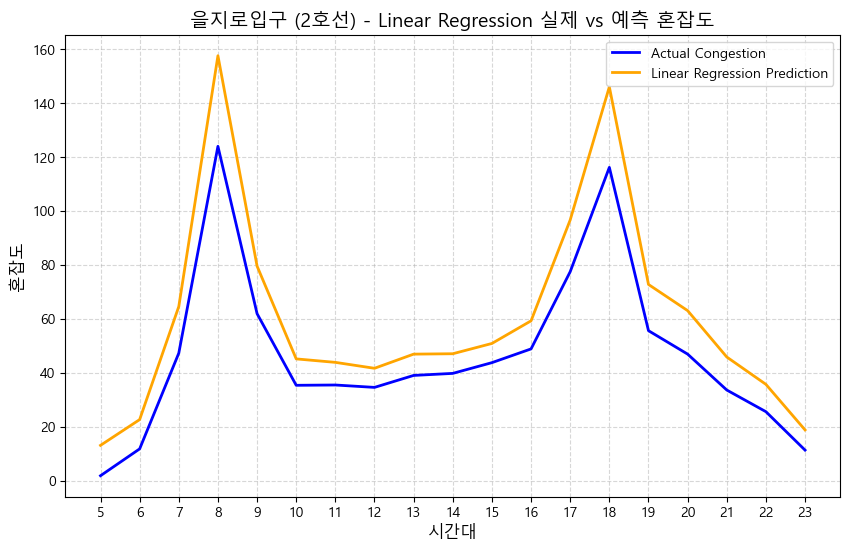

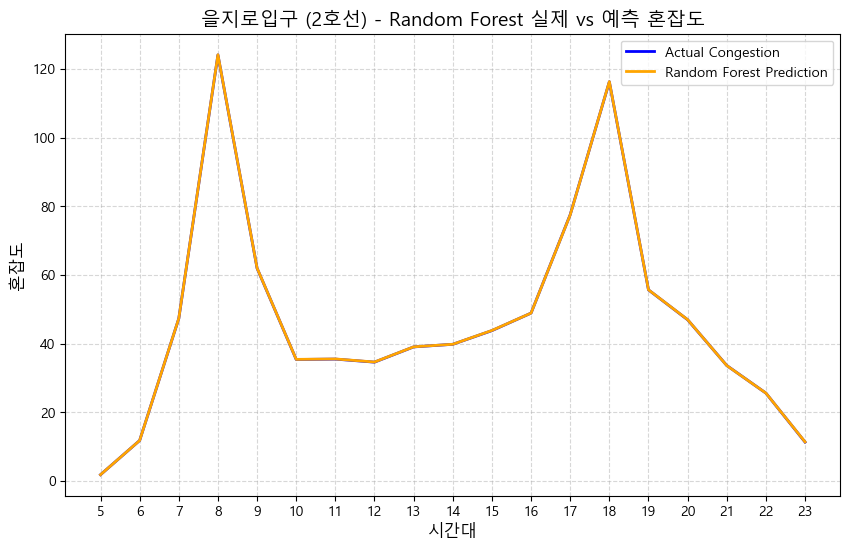

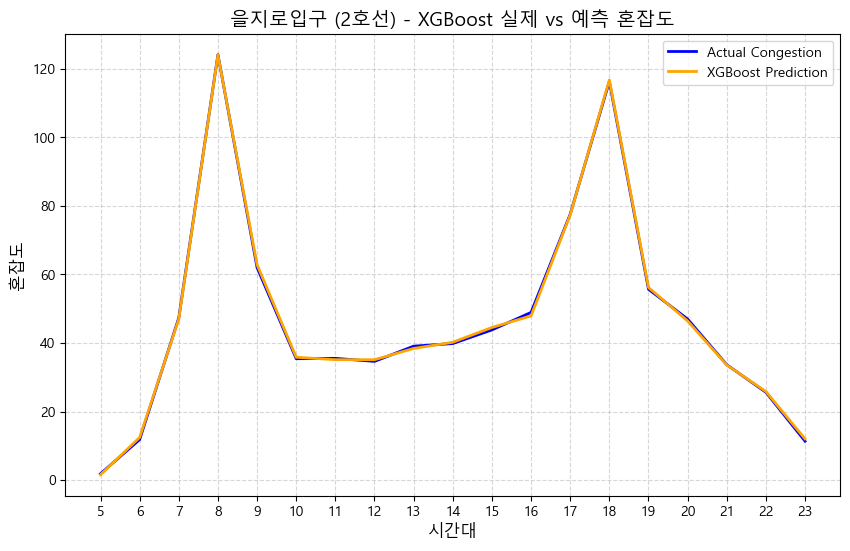

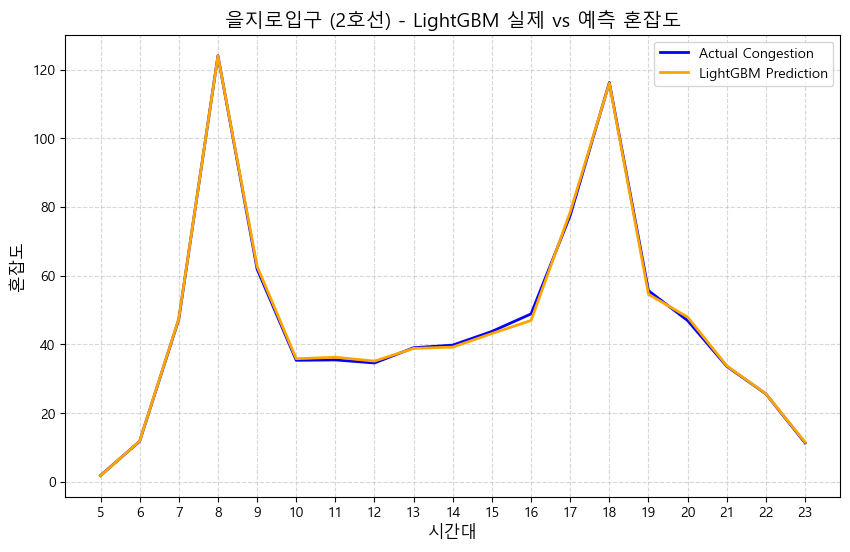

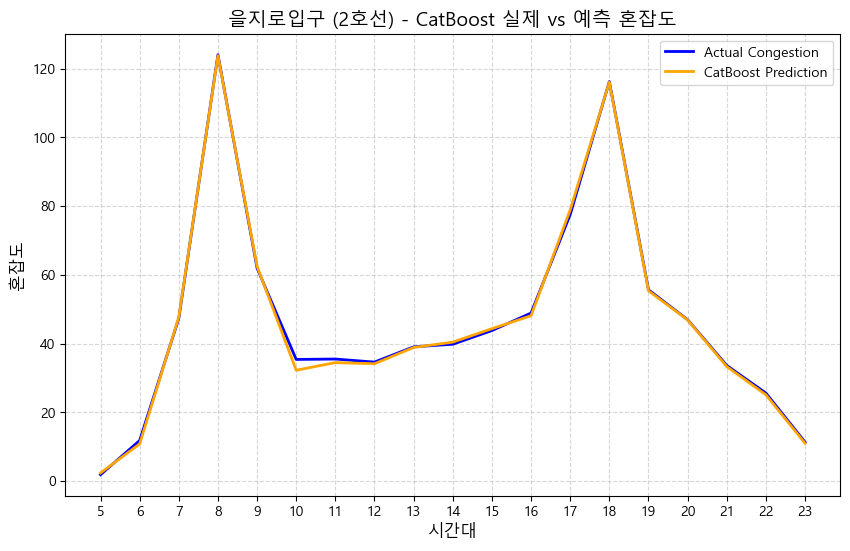

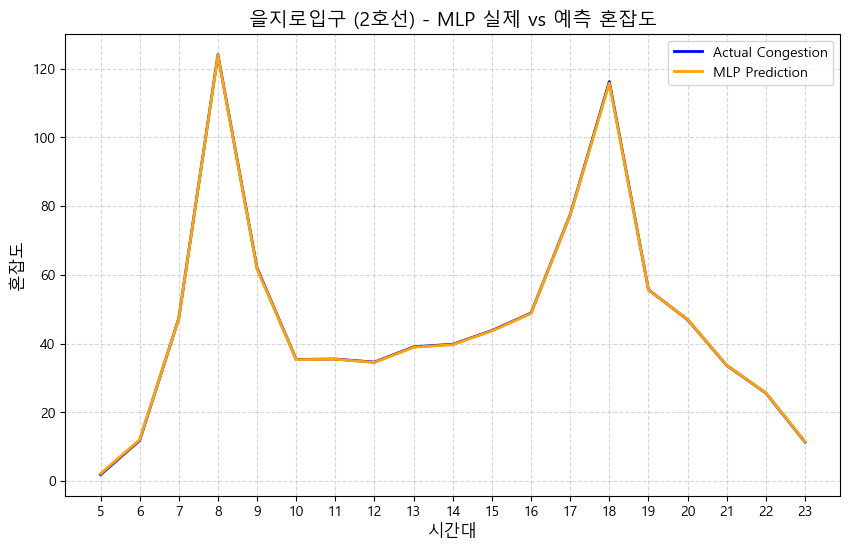

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step


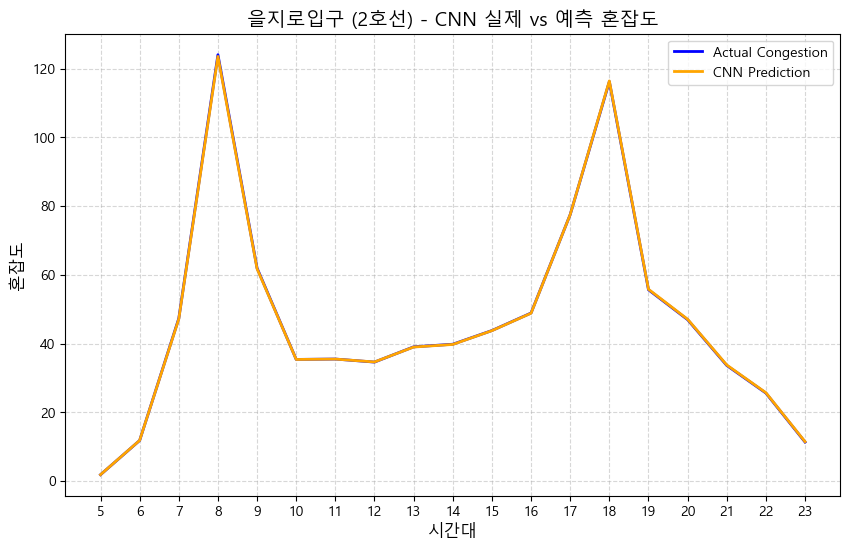

In [12]:
def plot_2d(station_name, line_number):
    
    station_data = data['df_test'][(data['df_test']['역명'] == station_name) & 
                                   (data['df_test']['호선'] == line_number)]
    
    # 시간대별 실제 혼잡도 평균 계산 및 정렬
    station_data = station_data.sort_values(by='시간')
    time_series = station_data['시간'].unique()
    actual_congestion = station_data.groupby('시간')['승강장혼잡도1'].mean()
    
    # 모델별 예측값 시각화
    for model_name, best_model in trained_models.items():
        try:
            X_test_station_scaled = data['scaler'].transform(station_data[data['feature_columns']])
            if model_name == 'CNN':
                X_test_model_input = X_test_station_scaled.reshape(-1, X_test_station_scaled.shape[1], 1)
            else:
                X_test_model_input = X_test_station_scaled

            # 예측
            Y_test_pred = best_model.predict(X_test_model_input)
            if model_name == 'CNN':
                Y_test_pred = Y_test_pred.flatten()
            
            # 시간대별 예측 값 평균 
            predicted_congestion = [Y_test_pred[station_data['시간'] == t].mean() for t in time_series]
            
            plt.figure(figsize=(10, 6))
            plt.plot(time_series, actual_congestion, label='Actual Congestion', color='blue', linewidth=2)
            plt.plot(time_series, predicted_congestion, label=f'{model_name} Prediction', color='orange', linewidth=2)
            plt.title(f'{station_name} ({line_number}호선) - {model_name} 실제 vs 예측 혼잡도', fontsize=14)
            plt.xlabel('시간대', fontsize=12)
            plt.ylabel('혼잡도', fontsize=12)
            plt.xticks(time_series)
            plt.grid(visible=True, linestyle='--', alpha=0.5)
            plt.legend()
            plt.show()
        except Exception as e:
            print(f"Error plotting predictions for {model_name}: {e}")

# 출력(서울역과 을지로입구역)
plot_2d('서울역', 1)
plot_2d('서울역', 4)
plot_2d('을지로입구', 2)

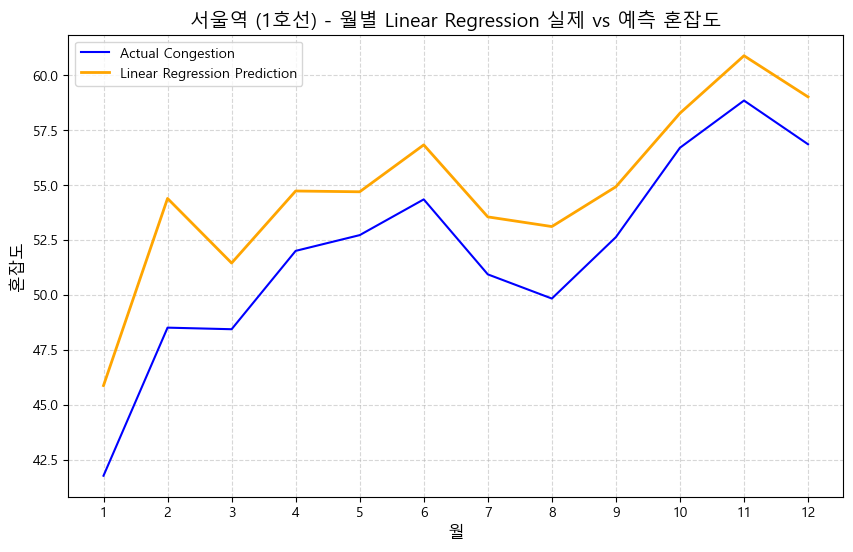

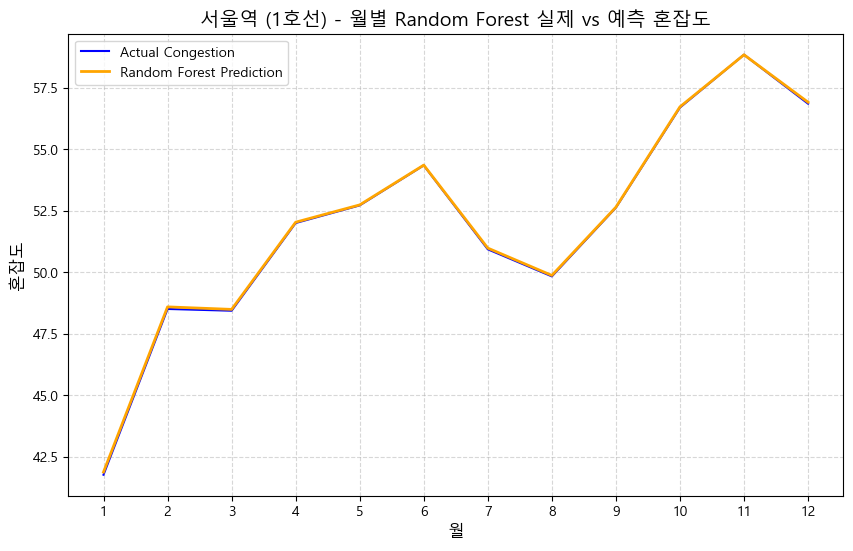

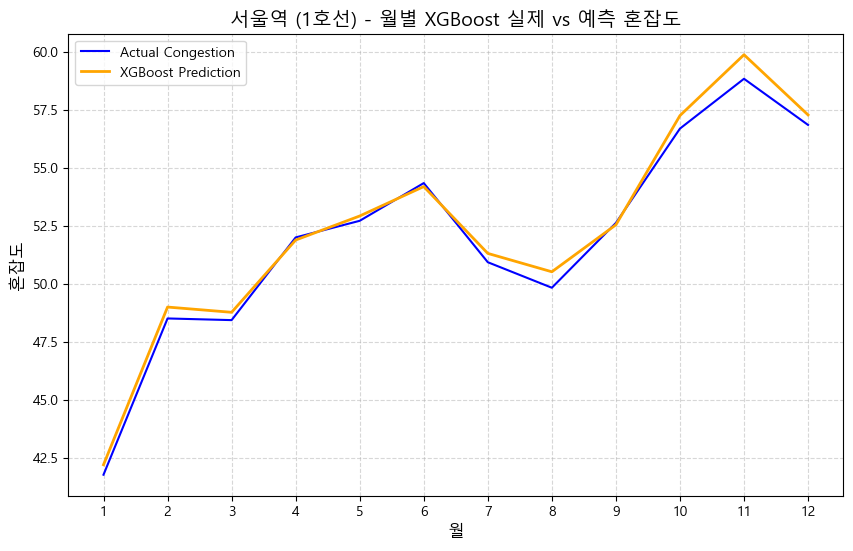

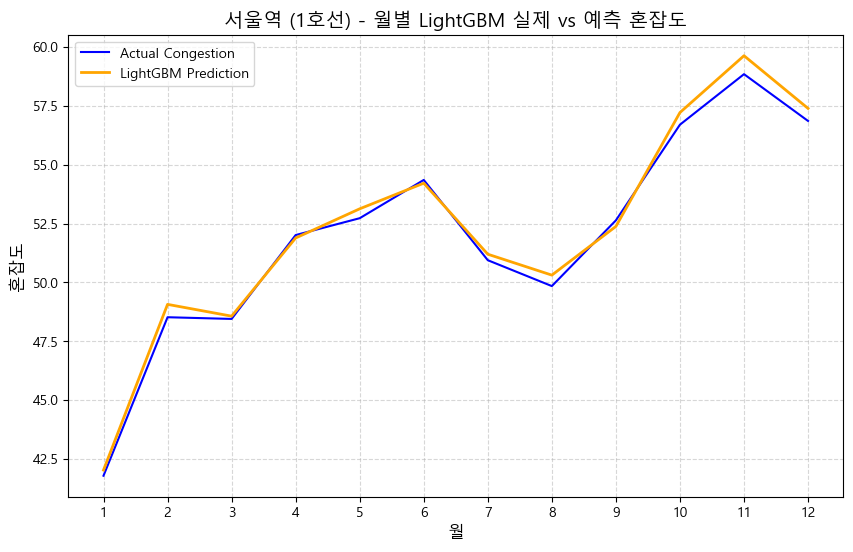

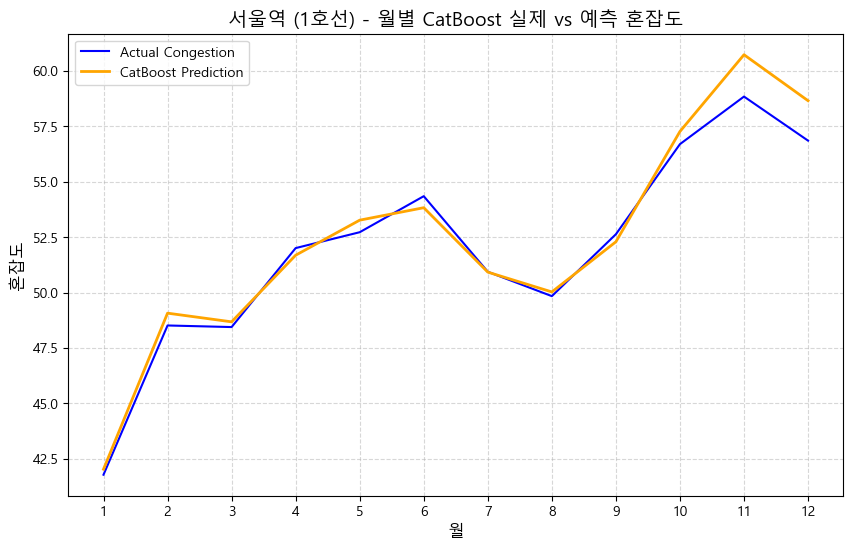

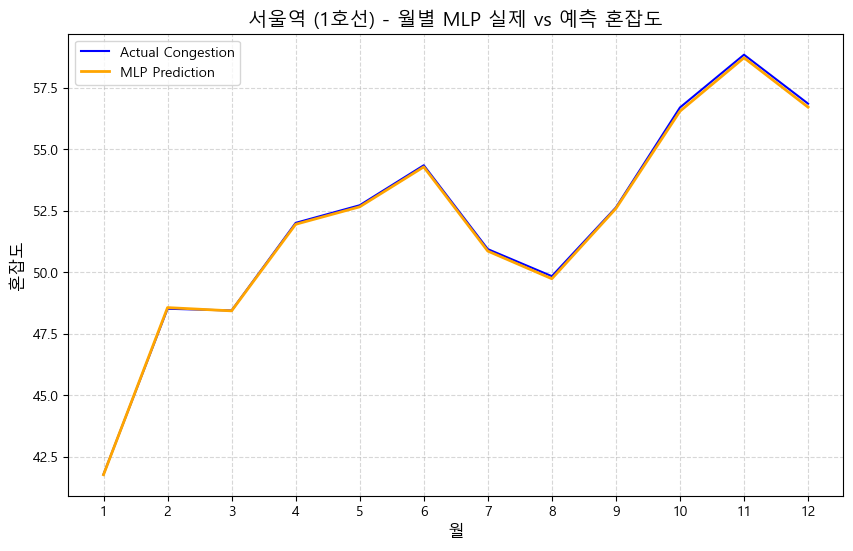

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


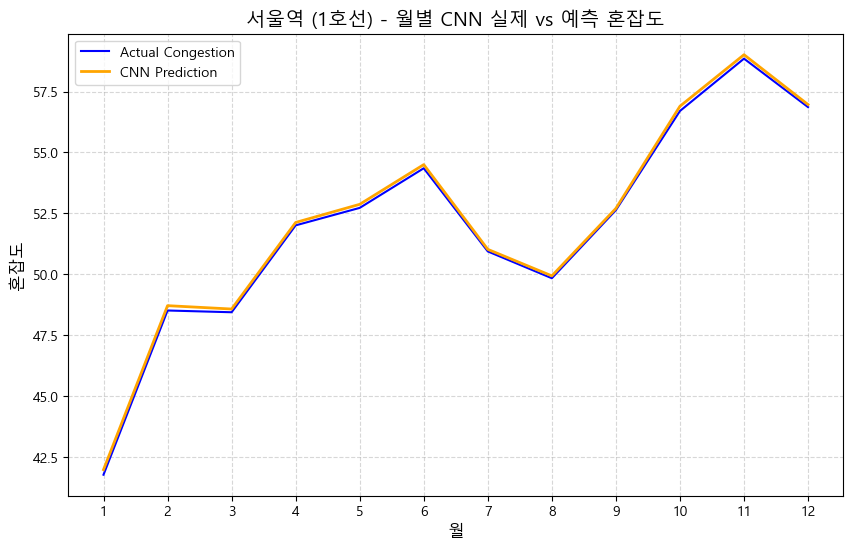

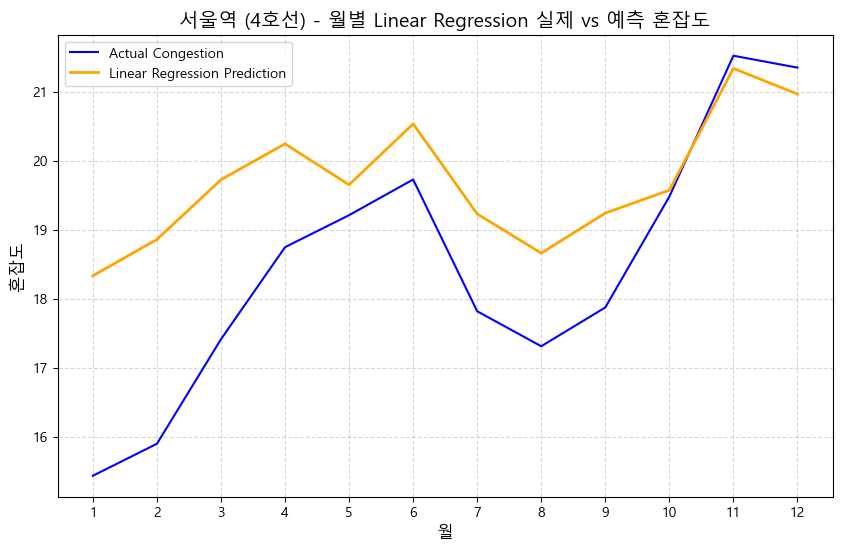

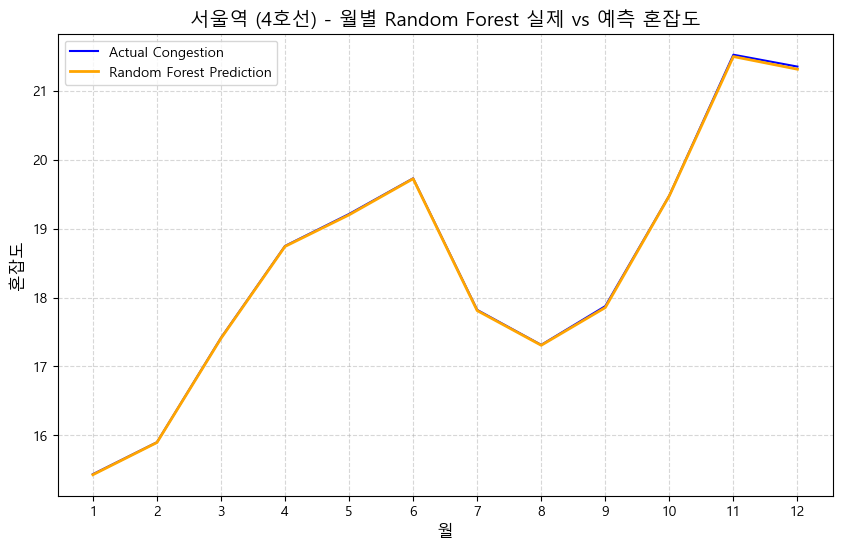

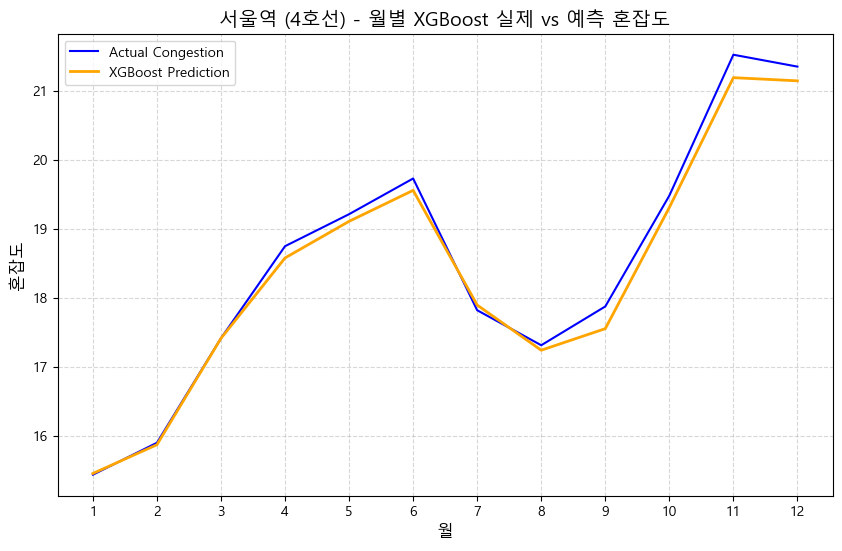

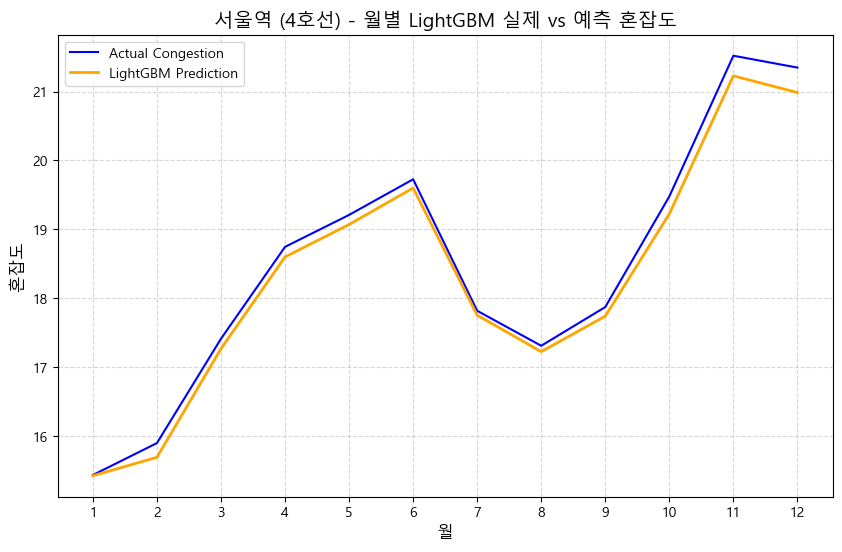

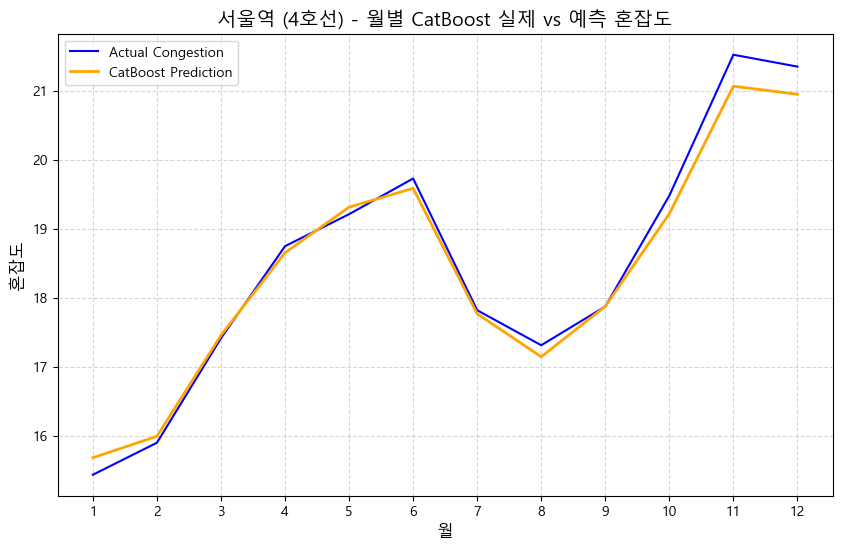

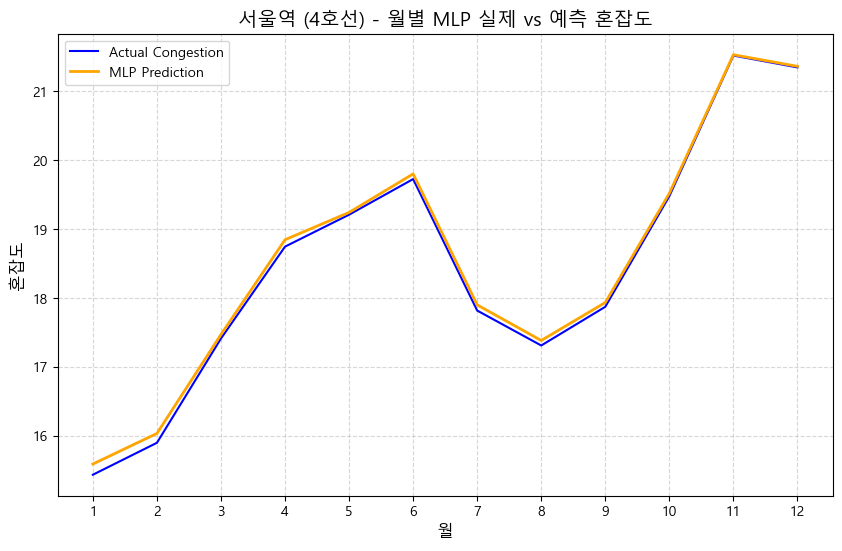

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


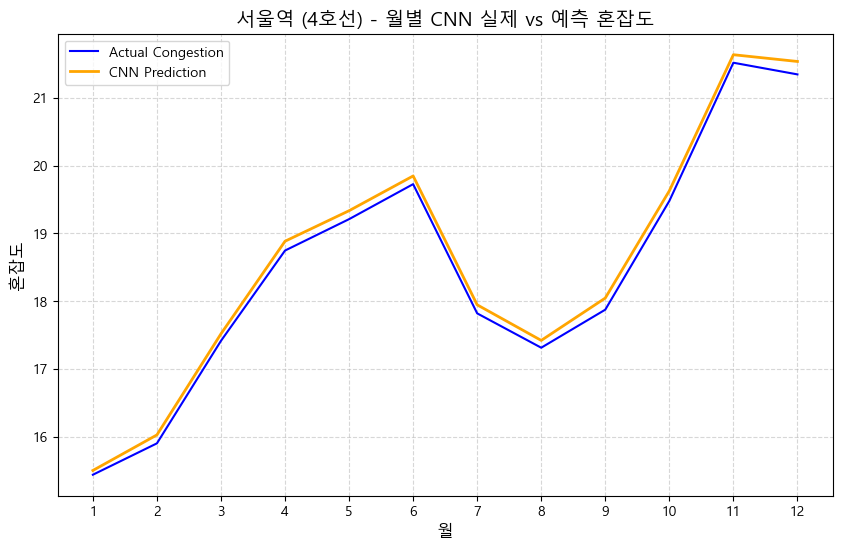

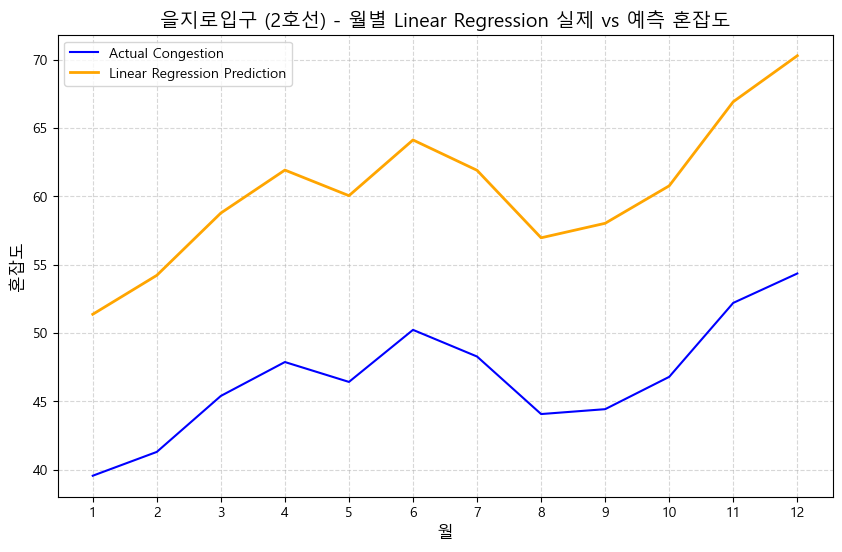

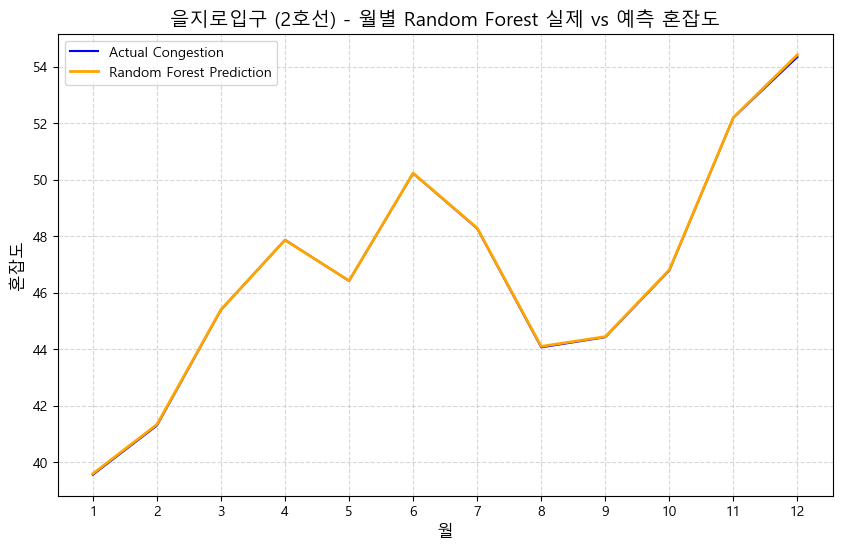

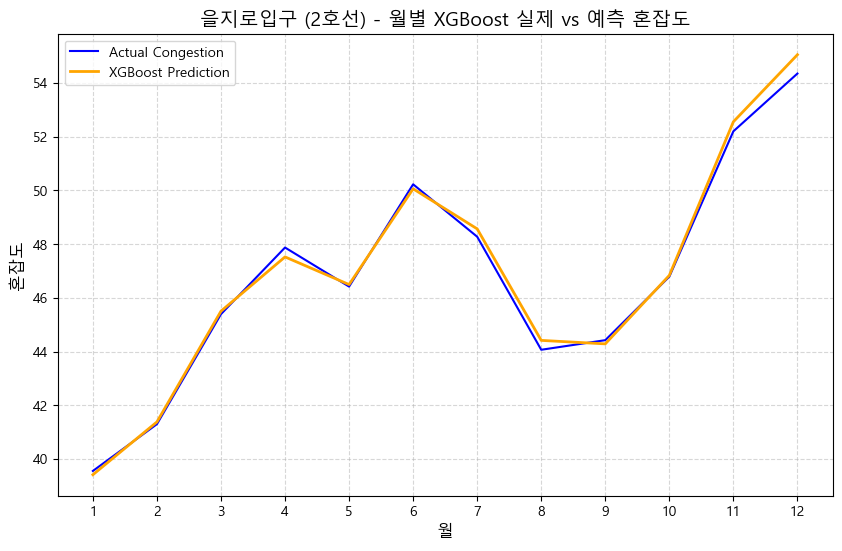

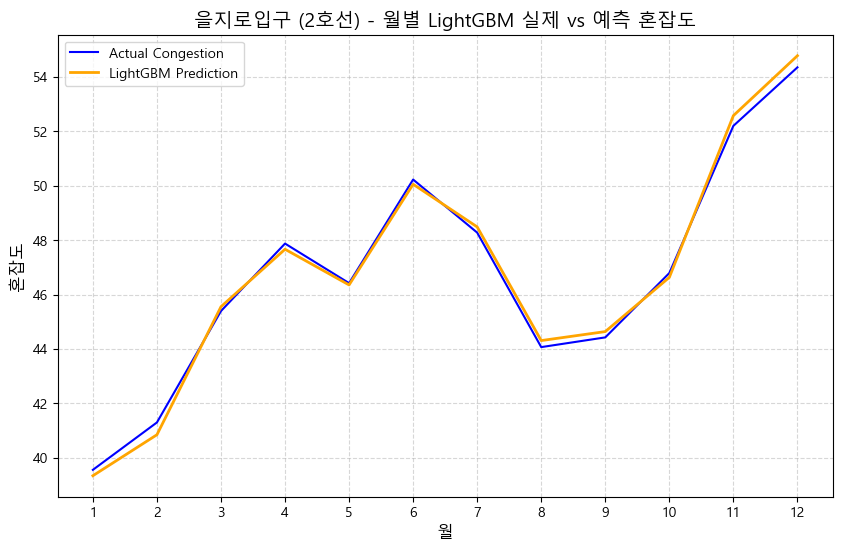

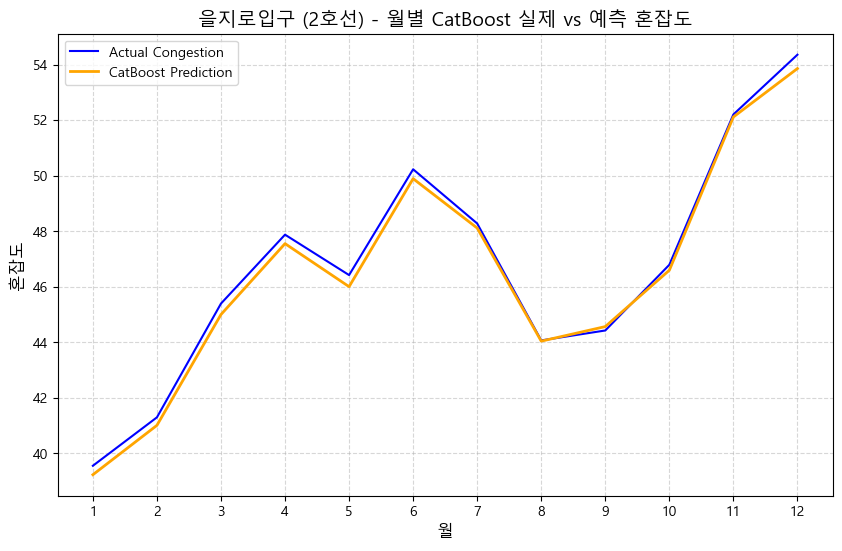

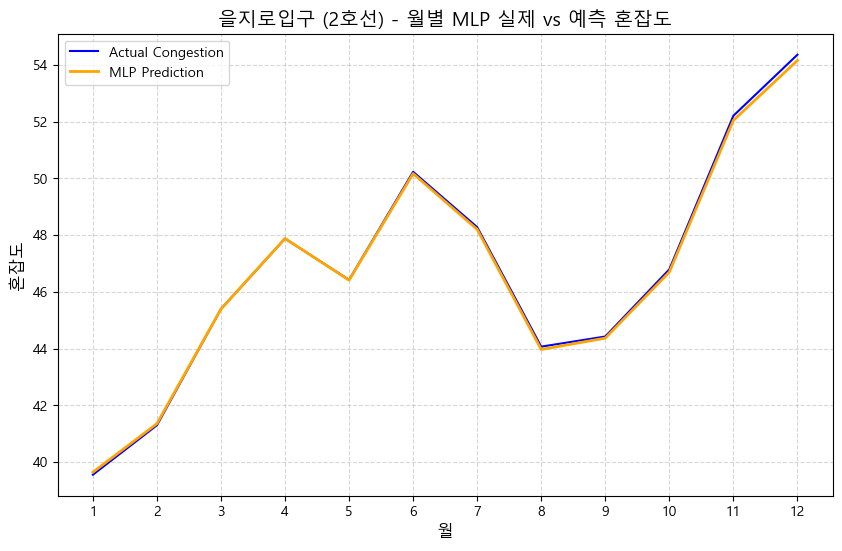

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step


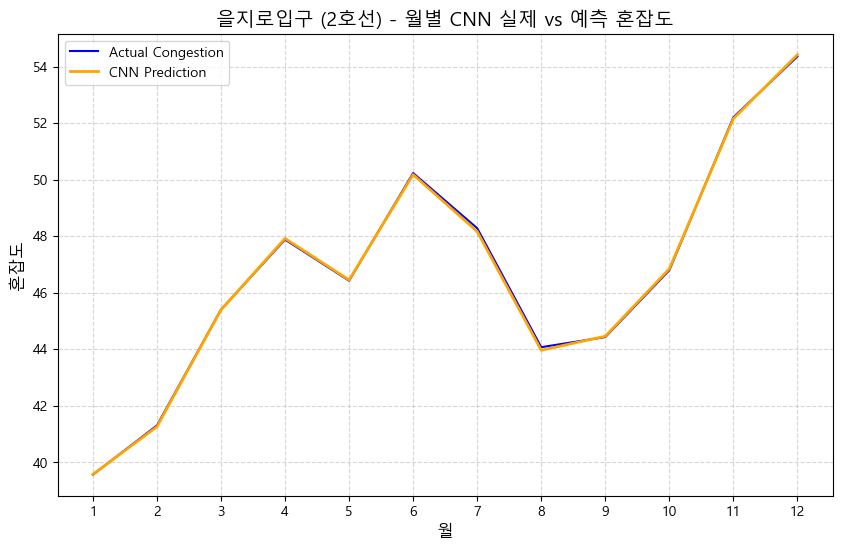

In [13]:
def plot_2d_2(station_name, line_number):
    station_data = data['df_test'][(data['df_test']['역명'] == station_name) & 
                                   (data['df_test']['호선'] == line_number)]
    
    # 순서대로 정렬
    station_data = station_data.sort_values(by='월')
    monthly_series = sorted(station_data['월'].unique())
    actual_congestion = station_data.groupby('월')['승강장혼잡도1'].mean()
    
    # 모델별 예측값 시각화
    for model_name, best_model in trained_models.items():
        try:
            X_test_station_scaled = data['scaler'].transform(station_data[data['feature_columns']])
            if model_name == 'CNN':
                X_test_model_input = X_test_station_scaled.reshape(-1, X_test_station_scaled.shape[1], 1)
            else:
                X_test_model_input = X_test_station_scaled

            # 예측
            Y_test_pred = best_model.predict(X_test_model_input)
            if model_name == 'CNN':
                Y_test_pred = Y_test_pred.flatten()
            
            # 월별 예측 값 평균 계산
            predicted_congestion = [Y_test_pred[station_data['월'] == month].mean() for month in monthly_series]
            
            plt.figure(figsize=(10, 6))
            plt.plot(monthly_series, actual_congestion, label='Actual Congestion', color='blue')
            plt.plot(monthly_series, predicted_congestion, label=f'{model_name} Prediction', color='orange', linewidth=2)
            plt.title(f'{station_name} ({line_number}호선) - 월별 {model_name} 실제 vs 예측 혼잡도', fontsize=14)
            plt.xlabel('월', fontsize=12)
            plt.ylabel('혼잡도', fontsize=12)
            plt.xticks(monthly_series)
            plt.grid(visible=True, linestyle='--', alpha=0.5)
            plt.legend()
            plt.show()
        except Exception as e:
            print(f"Error plotting predictions for {model_name}: {e}")

# 출력
plot_2d_2('서울역', 1)
plot_2d_2('서울역', 4)
plot_2d_2('을지로입구', 2)

# 6. Shap 분석

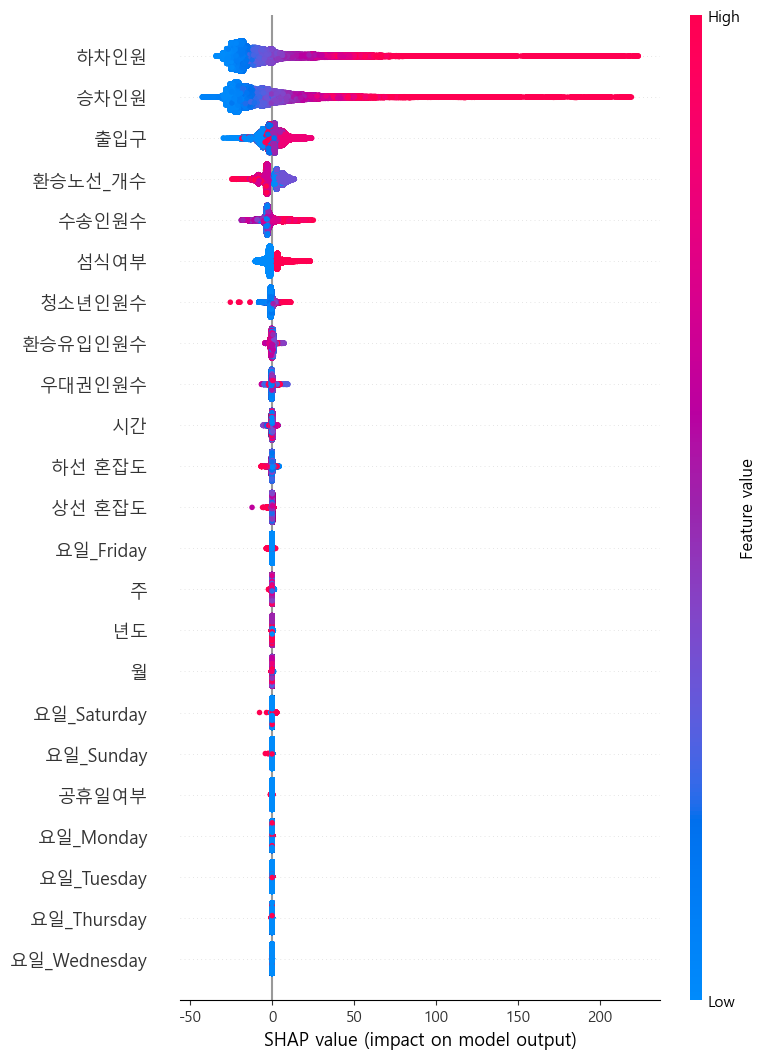

In [14]:
best_xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=0)
best_xgb_model.fit(data['X_train_scaled'], data['Y_train'])

# SHAP 분석
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(data['X_test_scaled'])

# SHAP 요약 플롯
shap.summary_plot(shap_values, data['X_test'], feature_names=data['feature_columns'], max_display=100)

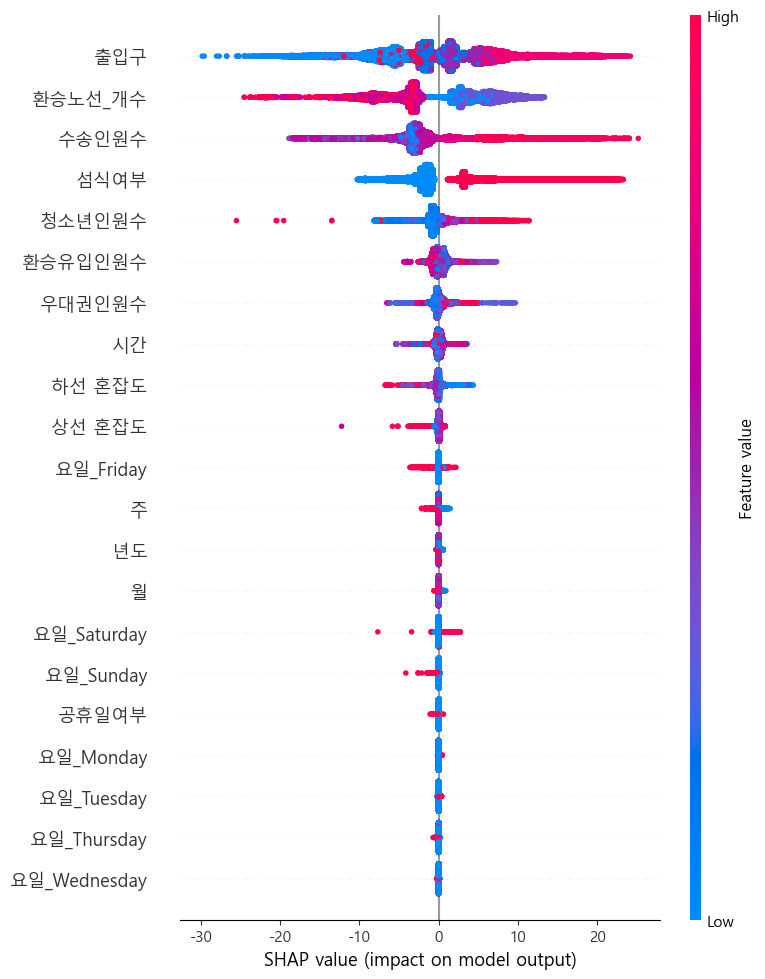

In [15]:
# 제외할 변수 목록
exclude_features = ['하차인원', '승차인원']

# 제외할 변수의 인덱스를 찾음
exclude_indices = [data['feature_columns'].index(feature) for feature in exclude_features]

# 제외한 SHAP 값 및 데이터 생성
shap_values_filtered = shap_values.copy()
shap_values_filtered = np.delete(shap_values_filtered, exclude_indices, axis=1)

# 제외한 데이터셋 생성
X_test_filtered = data['X_test'].copy()
X_test_filtered = X_test_filtered.drop(columns=exclude_features)

# 제외된 변수를 반영한 SHAP 요약 플롯
shap.summary_plot(shap_values_filtered, X_test_filtered, feature_names=X_test_filtered.columns.tolist(), max_display=100)

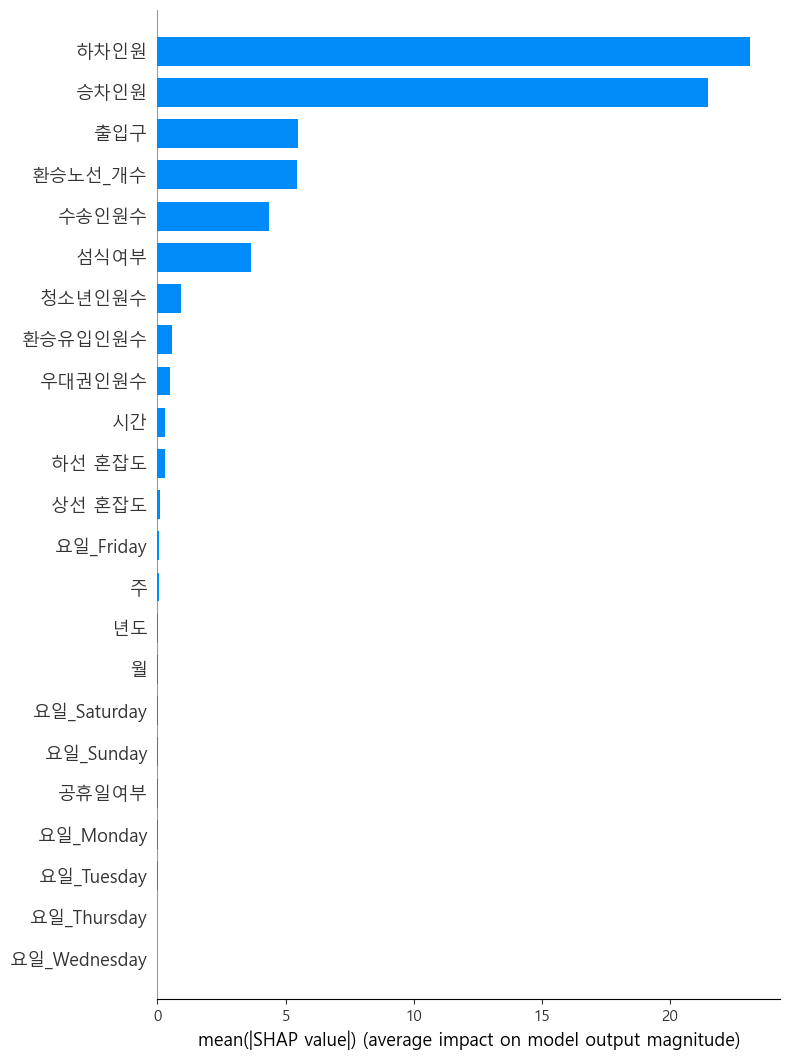

In [16]:
shap.summary_plot(shap_values, data['X_test'], feature_names=data['feature_columns'], plot_type="bar", max_display=100)

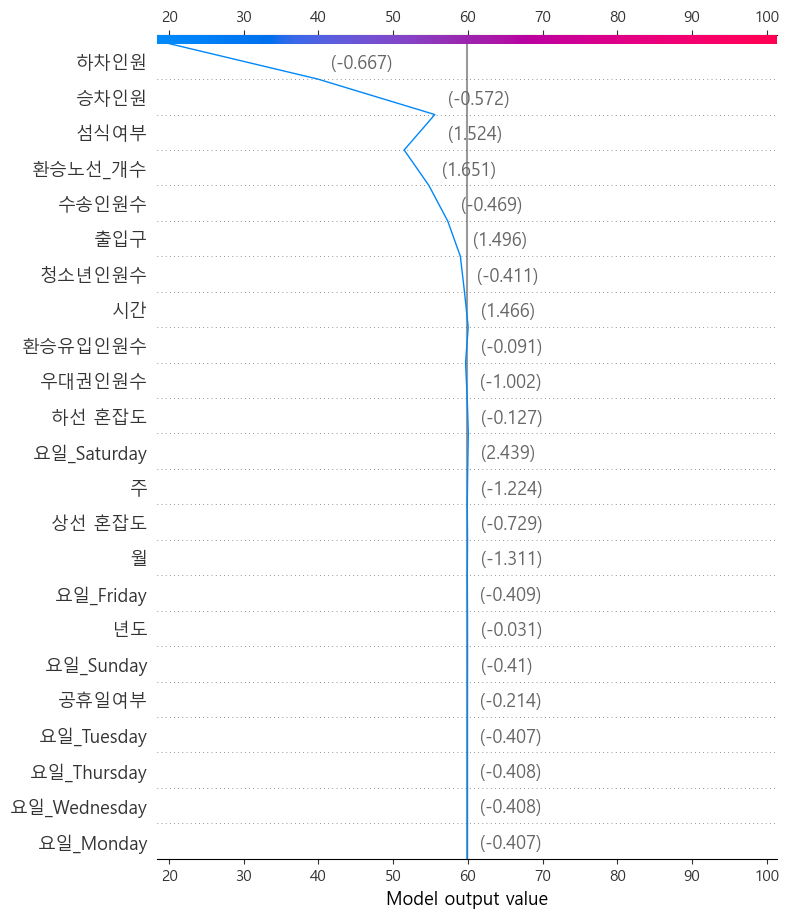

In [17]:
# 서울역 1호선
station_data = data['df_test'][(data['df_test']['역명'] == '서울역') & (data['df_test']['호선'] == 1)]

instance_index = station_data.index[0] 
X_test_station_scaled = data['scaler'].transform(station_data[data['feature_columns']])
X_test_scaled_df = pd.DataFrame(X_test_station_scaled, columns=data['feature_columns'])

# TreeExplainer 생성
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_station_scaled)

# SHAP Decision Plot _첫 번째 인스턴스
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[0],  
    features=X_test_scaled_df.iloc[0],  
    feature_names=data['feature_columns'],
    feature_display_range=slice(None, -99, -1)
)

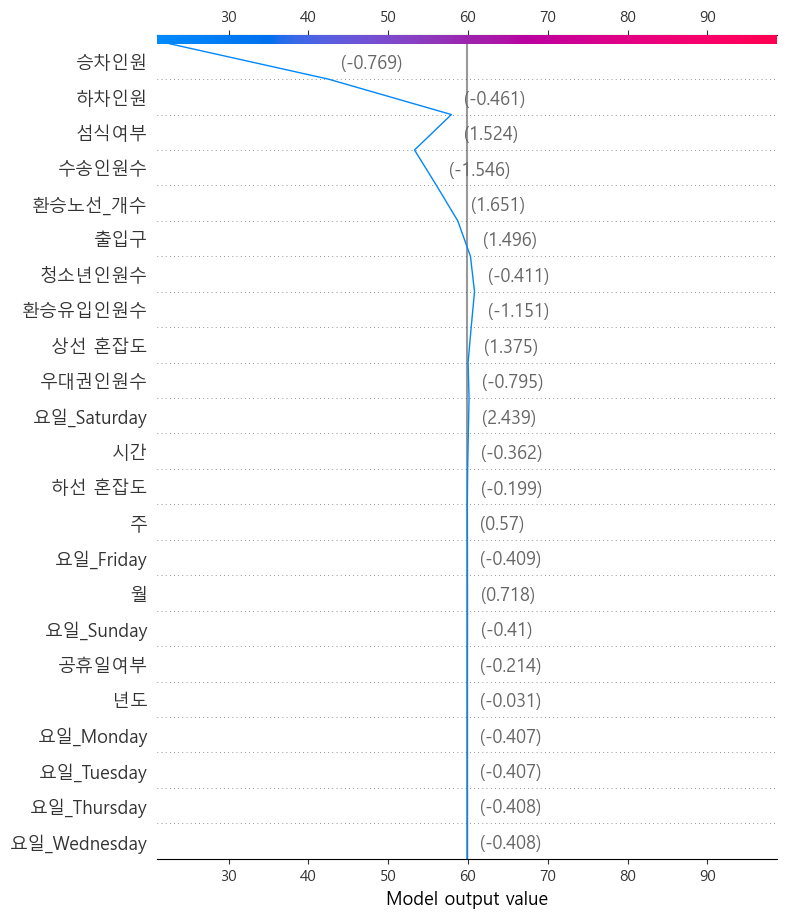

In [18]:
# 서울역 4호선
station_data = data['df_test'][(data['df_test']['역명'] == '서울역') & (data['df_test']['호선'] == 4)]

# station_data에서 첫 번째 데이터 포인트 사용
instance_index = station_data.index[0]  
X_test_station_scaled = data['scaler'].transform(station_data[data['feature_columns']])
X_test_scaled_df = pd.DataFrame(X_test_station_scaled, columns=data['feature_columns'])

# TreeExplainer 생성
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_station_scaled)

# Decision Plot 
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[0],  
    features=X_test_scaled_df.iloc[0],
    feature_names=data['feature_columns'],
    feature_display_range=slice(None, -99, -1)
)

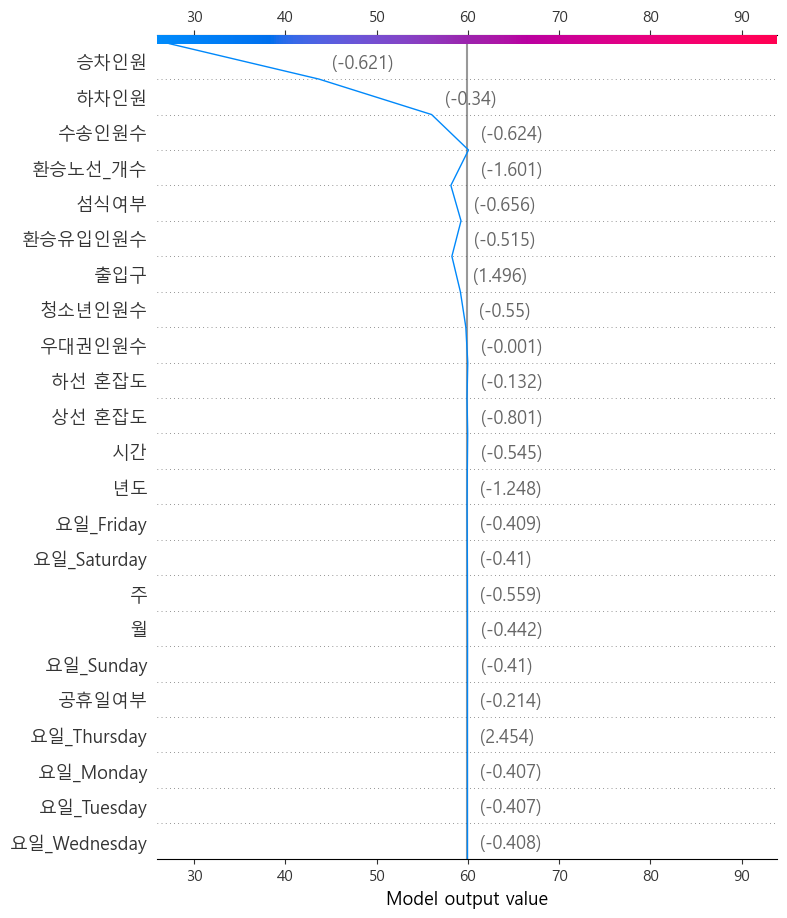

In [19]:
# 을지로 입구 2호선
station_data = data['df_test'][(data['df_test']['역명'] == '을지로입구') & (data['df_test']['호선'] == 2)]

# 첫 번째 데이터 포인트 사용
instance_index = station_data.index[955] 
X_test_station_scaled = data['scaler'].transform(station_data[data['feature_columns']])
X_test_scaled_df = pd.DataFrame(X_test_station_scaled, columns=data['feature_columns'])

# TreeExplainer 생성
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_station_scaled)

# Decision Plot 
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[0], 
    features=X_test_scaled_df.iloc[0],  
    feature_names=data['feature_columns'],
    feature_display_range=slice(None, -99, -1)
)